### Exploratory Data Analysis

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
data_adult=pd.read_csv('C:/Users/Julia/Documents/_DATA SCIENCE/_Capstones/Capstone 2/Data/Data_adult.csv',index_col=0)
sns.set(style='ticks')
%matplotlib inline 

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [3]:
data_adult.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4313 entries, 0 to 4313
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4313 non-null   object 
 1   age                4313 non-null   float64
 2   hypertension       4313 non-null   int64  
 3   heart_disease      4313 non-null   int64  
 4   ever_married       4313 non-null   object 
 5   work_type          4313 non-null   object 
 6   Residence_type     4313 non-null   object 
 7   avg_glucose_level  4313 non-null   float64
 8   bmi                4130 non-null   float64
 9   smoking_status     4313 non-null   object 
 10  stroke             4313 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 404.3+ KB


### Target feature:
### Since the goal of this project is to predict occurence of stroke, target feature is 'stroke'. It has 2 values: 1 - when a patient had a stroke, and 0  - when a patient did not have a stroke.

In [4]:
data_adult['stroke'].value_counts(normalize=True)*100

0    94.273128
1     5.726872
Name: stroke, dtype: float64

### It is obvious that target feature is highly imbalanced with only ~ 5.72 % of samples having a value of 1. This is a major issue and may require application of specialized feature engineering techniques as well as careful model selection and it may affect a perfomance of a selected model. 

### Dealing with missing values

In [5]:
data_adult.isna().any()

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

### 'bmi' feature is the only one that has missing values

In [6]:
data_adult['bmi'].isna().sum()

183

In [7]:
percent_missing = data_adult['bmi'].isnull().sum() * 100 / len(data_adult)
print('Percentage of missing values in "bmi" feature:', round(percent_missing,2))

Percentage of missing values in "bmi" feature: 4.24


In [8]:
no_na = data_adult.dropna()
no_na['stroke'].value_counts(normalize=True)*100

0    94.96368
1     5.03632
Name: stroke, dtype: float64

### Even though percentage of missing values in a dataset is relatively small, it is not a good idea to simply drop rows with missing values, as this will make target feature even more imbalanced.

<AxesSubplot:>

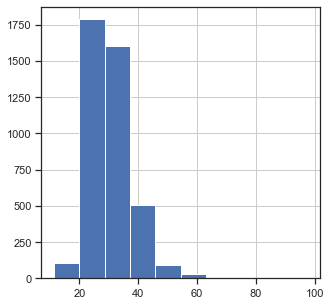

In [9]:
data_adult['bmi'].hist(figsize=(5,5))

### Distribution of 'bmi' values is skewed, meaning that we cannot impute missing values with the mean.

<AxesSubplot:xlabel='stroke', ylabel='bmi'>

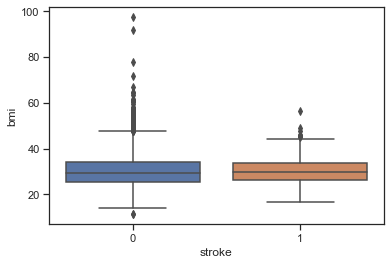

In [10]:
sns.boxplot(x="stroke", y="bmi", data=data_adult)

### Since 'bmi' feature is scewed, the relationship between 'bmi' and target value is not clear. I think it would make sense to divide 'bmi' values into following categories:
* below 18.5 – underweight
* between 18.5 and 24.9 – healthy weight
* between 25 and 29.9 – overweight
* between 30 and 39.9 – obesity

In [11]:
for val in data_adult['bmi']:
    if val < 18.5:
        data_adult['bmi'].replace(to_replace=val, value='underweight', inplace=True)
    elif val >= 18.5 and val <= 24.9:
        data_adult['bmi'].replace(to_replace=val, value='normal', inplace=True)
    elif val >= 25 and val <= 29.9:
        data_adult['bmi'].replace(to_replace=val, value='overweight', inplace=True)
    elif val >= 30:
        data_adult['bmi'].replace(to_replace=val, value='obesity', inplace=True)

In [12]:
data_adult['bmi'].unique()

array(['obesity', nan, 'normal', 'overweight', 'underweight'],
      dtype=object)

In [13]:
data_adult['bmi'].value_counts(normalize=True)

obesity        0.453027
overweight     0.322276
normal         0.215012
underweight    0.009685
Name: bmi, dtype: float64

### Now that we've divided 'bmi' feature into categories, we can replace missing values using 'ffill' method which seems to be optimal.

In [14]:
#data_adult['bmi']=data_adult['bmi'].fillna(data_adult['bmi'].mode()[0])

In [15]:
data_adult['bmi']=data_adult['bmi'].fillna(method ='ffill')

<AxesSubplot:xlabel='bmi', ylabel='stroke'>

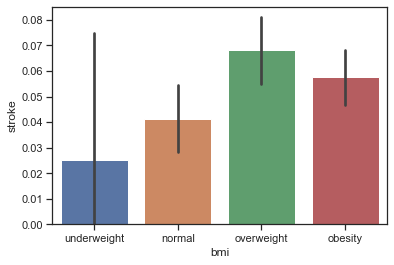

In [16]:
sns.barplot(x='bmi',y='stroke',data=data_adult, order=["underweight", "normal","overweight","obesity"])

### Plot above clearly shows that 'bmi' categories 'overweight' and 'obesity' have higher occurence of value 1 in the target feature.

In [17]:
data_adult.isna().any()

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                  False
smoking_status       False
stroke               False
dtype: bool

### There are no more missing values in the data set.

### Continuous variables

In [18]:
data_adult.describe(include='float64')

,age,avg_glucose_level
count,4313.000000,4313.000000
mean,49.745885,108.226388
std,18.125129,47.568050
min,17.000000,55.120000
25%,35.000000,77.450000
50%,50.000000,92.270000
75%,64.000000,115.920000
max,82.000000,271.740000


<AxesSubplot:>

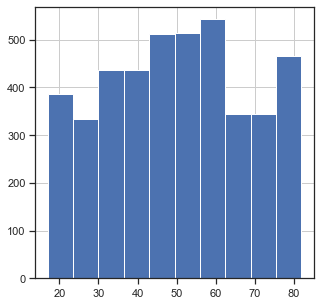

In [19]:
data_adult['age'].hist(figsize=(5,5))

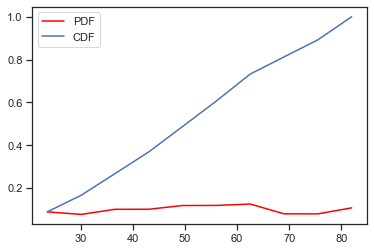

In [20]:
count, bins_count = np.histogram(data_adult['age'], bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()

### 'age' feature has uniform distribution.

<AxesSubplot:xlabel='stroke', ylabel='age'>

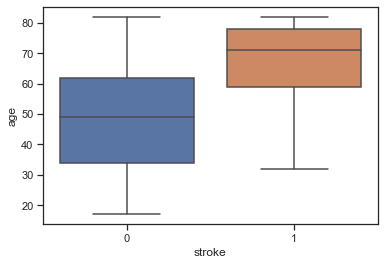

In [21]:
sns.boxplot(x='stroke', y='age', data=data_adult)

In [22]:
data_adult['age_bin'] = pd.cut(data_adult['age'],
                         [0, 18, 30, 45, 60, 80, 99])

In [23]:
data_adult = data_adult.drop(columns=['age'])

<AxesSubplot:xlabel='age_bin', ylabel='stroke'>

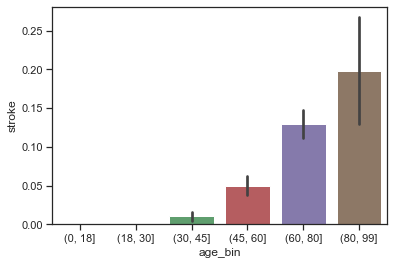

In [24]:
sns.barplot(x='age_bin', y='stroke', data=data_adult)

### The stroke occurs more often in people of higher age.

<AxesSubplot:>

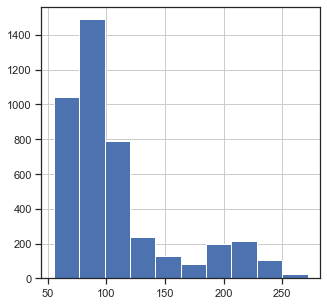

In [25]:
data_adult['avg_glucose_level'].hist(figsize=(5,5))

<AxesSubplot:xlabel='stroke', ylabel='avg_glucose_level'>

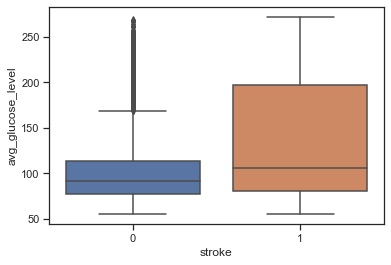

In [26]:
sns.boxplot(x='stroke', y='avg_glucose_level', data=data_adult)

In [27]:
for val in data_adult['avg_glucose_level']:
    if val < 140:
        data_adult['avg_glucose_level'].replace(to_replace=val, value='normal', inplace=True)
    elif val >= 140 and val < 200:
        data_adult['avg_glucose_level'].replace(to_replace=val, value='prediabetes', inplace=True)
    elif val >= 200:
        data_adult['avg_glucose_level'].replace(to_replace=val, value='diabetes', inplace=True)

In [28]:
data_adult.rename(columns = {'avg_glucose_level':'glucose_levels'}, inplace=True)

<AxesSubplot:xlabel='glucose_levels', ylabel='stroke'>

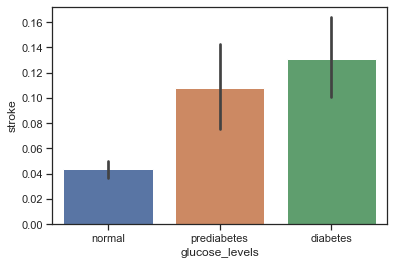

In [29]:
sns.barplot(x='glucose_levels',y='stroke',data=data_adult, order=["normal", "prediabetes","diabetes"])

### Demographic features: gender,age

<AxesSubplot:xlabel='age_bin', ylabel='stroke'>

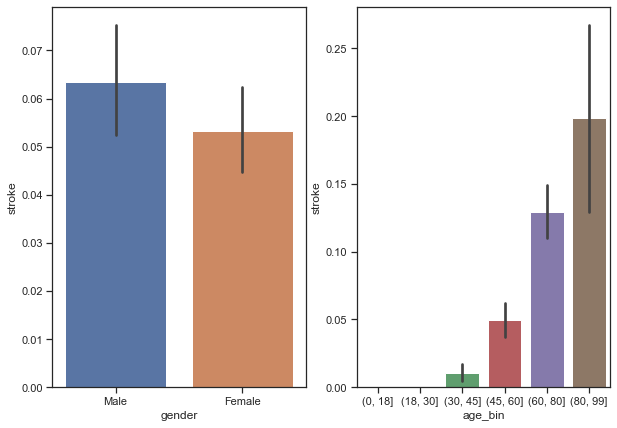

In [30]:
fig, axes = plt.subplots(1,2,figsize=(10, 7))
sns.barplot(ax=axes[0],x='gender',y='stroke',data=data_adult)
sns.barplot(ax=axes[1],x='age_bin', y='stroke', data=data_adult)

### Hypertension

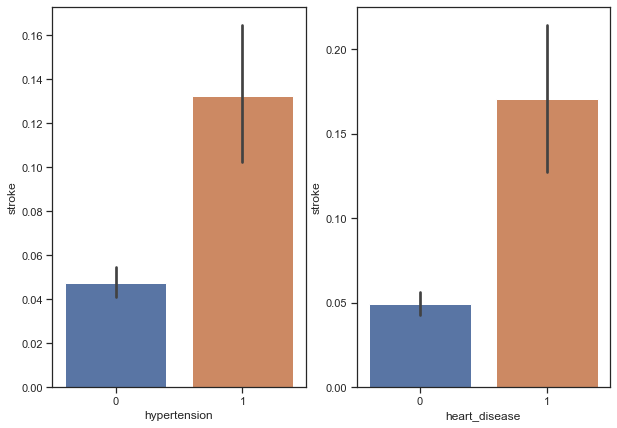

In [31]:
fig, axes = plt.subplots(1,2,figsize=(10, 7))
sns.barplot(ax=axes[0], x='hypertension',y='stroke',data=data_adult);
sns.barplot(ax=axes[1], x='heart_disease',y='stroke',data=data_adult);

### Stress

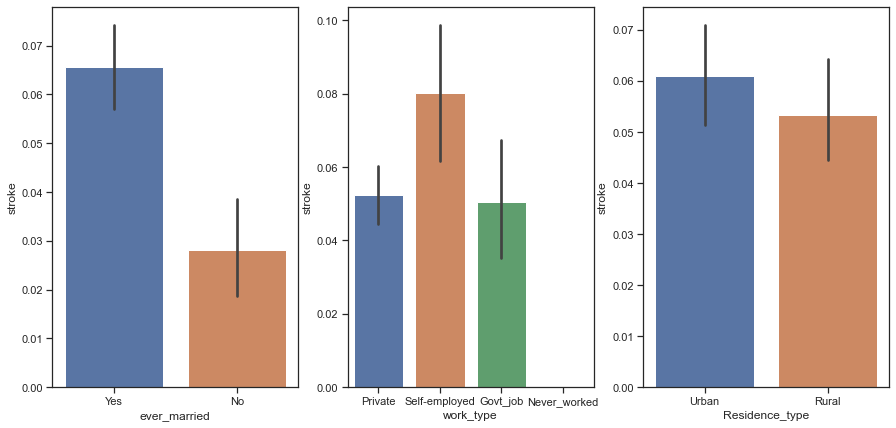

In [32]:
fig, axes = plt.subplots(1,3,figsize=(15, 7))
sns.barplot(ax=axes[0], x='ever_married',y='stroke',data=data_adult)
sns.barplot(ax=axes[1], x='work_type',y='stroke',data=data_adult)
sns.barplot(ax=axes[2], x='Residence_type',y='stroke',data=data_adult);

### Smoking status

<AxesSubplot:xlabel='smoking_status', ylabel='stroke'>

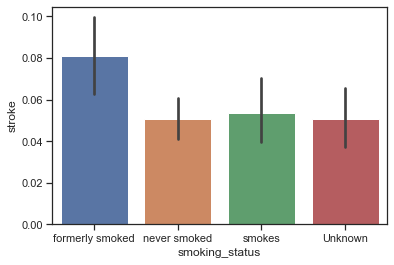

In [33]:
sns.barplot(x='smoking_status',y='stroke',data=data_adult)

### Feature selection

In [34]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from mlxtend.preprocessing import minmax_scaling
import scipy.stats

In [35]:
data_adult.head()

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,glucose_levels,bmi,smoking_status,stroke,age_bin
0,Male,0,1,Yes,Private,Urban,diabetes,obesity,formerly smoked,1,"(60, 80]"
1,Female,0,0,Yes,Self-employed,Rural,diabetes,obesity,never smoked,1,"(60, 80]"
2,Male,0,1,Yes,Private,Rural,normal,obesity,never smoked,1,"(60, 80]"
3,Female,0,0,Yes,Private,Urban,prediabetes,obesity,smokes,1,"(45, 60]"
4,Female,1,0,Yes,Self-employed,Rural,prediabetes,normal,never smoked,1,"(60, 80]"


In [36]:
# Label encoding or dummies???

In [37]:
X1 = data_adult.copy()

In [38]:
for col in data_adult.columns:
    data_adult[col] = LabelEncoder().fit_transform(data_adult[col])

In [39]:
#data_adult = pd.get_dummies(data_adult,drop_first=True)

In [40]:
#df_scaled = minmax_scaling(data_adult,columns=data_adult.columns.values)

<AxesSubplot:>

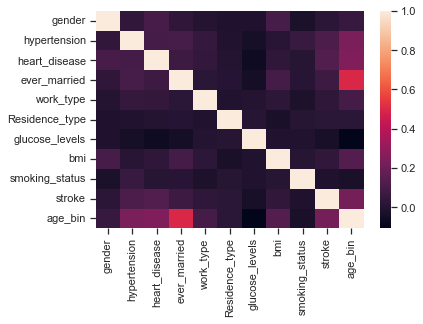

In [41]:
sns.heatmap(data_adult.corr())

In [42]:
features = [col for col in data_adult.columns if col != 'stroke']

# Make an explanatory variable called X, and assign it: NoPrediction[features]
X = data_adult[features] 

# Make a dependent variable called y, and assign it: NoPrediction.Decision
y = data_adult[['stroke']] 

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=246)

In [44]:
# define feature selection
def feature_selection(variable_counts,score_function):
    selection_model = SelectKBest(score_func=score_function, k=variable_counts)
    selection = selection_model.fit(X_train,y_train)
    features_selected = X_train.columns[selection.get_support()]
    X_train_selected = selection_model.fit_transform(X_train,y_train)
    # calculating accuracy
    reg = LogisticRegression()
    reg.fit(X_train_selected,y_train)
    y_pred = reg.predict(X_test[features_selected])
    return metrics.accuracy_score(y_test,y_pred)

In [45]:
# create accuracy chart
accuracy_df = pd.DataFrame({'features count': [], 'accuracy':[], 'score function':[]})
function_list = [chi2, f_classif, mutual_info_classif]
function_name = ['chi square', 'anova', 'mutual information']

for j in range (len(function_list)):
    func = function_list[j]
    func_name = function_name[j]
    for i in range(1,len(X_train.columns)):
        accuracy = feature_selection(i,func)
        new_record = {'features count': round(i), 'accuracy':round(accuracy,3), 'score function':func_name}
        accuracy_df = accuracy_df.append(new_record, ignore_index=True)    

In [46]:
accuracy_df

,features count,accuracy,score function
0,1.0,0.941,chi square
1,2.0,0.941,chi square
2,3.0,0.941,chi square
3,4.0,0.941,chi square
4,5.0,0.941,chi square
5,6.0,0.941,chi square
6,7.0,0.941,chi square
7,8.0,0.942,chi square
8,9.0,0.942,chi square
9,1.0,0.941,anova


<AxesSubplot:xlabel='features count', ylabel='accuracy'>

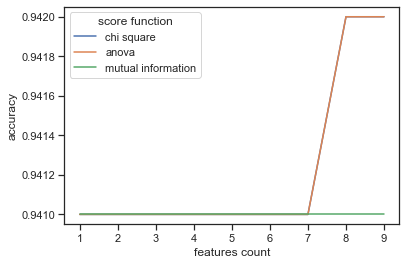

In [47]:
sns.lineplot(x='features count',y='accuracy',data=accuracy_df,hue='score function')

AxesSubplot(0.125,0.125;0.775x0.755)
         features     scores
9         age_bin  78.856838
2   heart_disease  35.513876
1    hypertension  27.971725
3    ever_married   4.028647
7             bmi   2.373993
6  glucose_levels   1.757819
8  smoking_status   0.537500
4       work_type   0.359759
5  Residence_type   0.329767
0          gender   0.013722
AxesSubplot(0.125,0.125;0.775x0.755)
         features      scores
9         age_bin  161.846671
2   heart_disease   38.305149
1    hypertension   31.821089
3    ever_married   18.391402
6  glucose_levels    9.653448
7             bmi    4.817051
4       work_type    0.879576
8  smoking_status    0.815236
5  Residence_type    0.667519
0          gender    0.022616
AxesSubplot(0.125,0.125;0.775x0.755)
         features    scores
9         age_bin  0.026795
6  glucose_levels  0.009398
2   heart_disease  0.005787
0          gender  0.004098
3    ever_married  0.003916
5  Residence_type  0.002432
8  smoking_status  0.000488
7             bm

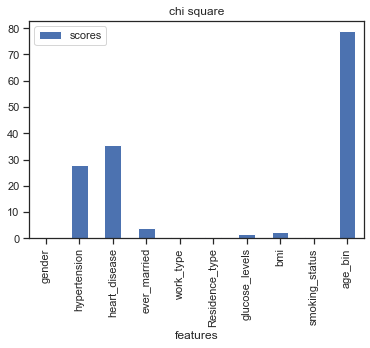

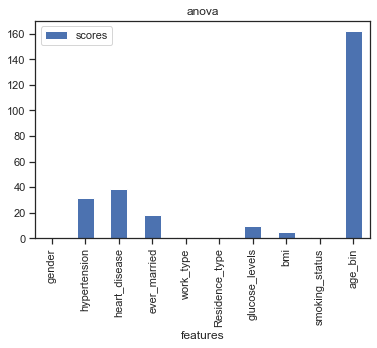

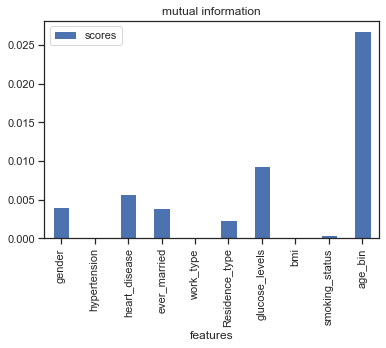

In [48]:
for i in range(len(function_list)):
    function = function_list[i]
    name = function_name[i]
    selection_model = SelectKBest(score_func=function, k=10).fit(X_train, y_train)
    feature_score = pd.DataFrame({'features': X_train.columns.values, 'scores':selection_model.scores_})
    print(feature_score.plot(x='features',kind='bar',title=name))
    print((feature_score.sort_values(by=['scores'],ascending=False)));

### Null hypothesis: an explanatory variable and target variable are independent.

## Calculate critical values to be able to reject null hypothesis?

In [49]:
critical_values = {}
for col in data_adult.columns:
    if col != 'stroke':
        crosstab = pd.crosstab(data_adult['stroke'], data_adult[col])
        df = (len(crosstab.index)-1)*(len(crosstab.columns)-1) #degrees of freedom
        crit_val = scipy.stats.chi2.ppf(0.5, df=df)
        critical_values[col] = crit_val

In [50]:
critical_values

{'gender': 0.454936423119572,
 'hypertension': 0.454936423119572,
 'heart_disease': 0.454936423119572,
 'ever_married': 0.454936423119572,
 'work_type': 2.3659738843753377,
 'Residence_type': 0.454936423119572,
 'glucose_levels': 1.386294361119891,
 'bmi': 2.3659738843753377,
 'smoking_status': 2.3659738843753377,
 'age_bin': 4.351460191095526}

### For all features, where chi-square score is < than critical value, null hypothesis is true and features can be dropped?

### Wrapper methods

### Forward selection

In [51]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [52]:
sfs = SFS(LogisticRegression(),k_features='best',forward=True,scoring='accuracy')
X_train_selected = sfs.fit_transform(X_train, y_train)
reg = LogisticRegression()
reg.fit(X_train_selected, y_train)
y_pred = reg.predict(X_test[list(sfs.k_feature_names_)])
sfs_accuracy = metrics.accuracy_score(y_test,y_pred)

In [53]:
#accuracy_df = pd.DataFrame({'features count': [], 'accuracy':[], 'score function':[]})
#for i in range()


In [54]:
sfs.k_feature_names_

('gender',)

In [55]:
sfs.subsets_

{1: {'feature_idx': (0,),
  'cv_scores': array([0.94435858, 0.94281298, 0.94281298, 0.94281298, 0.94427245]),
  'avg_score': 0.9434139945736695,
  'feature_names': ('gender',)},
 2: {'feature_idx': (0, 1),
  'cv_scores': array([0.94435858, 0.94281298, 0.94281298, 0.94281298, 0.94427245]),
  'avg_score': 0.9434139945736695,
  'feature_names': ('gender', 'hypertension')},
 3: {'feature_idx': (0, 1, 2),
  'cv_scores': array([0.94435858, 0.94281298, 0.94281298, 0.94281298, 0.94427245]),
  'avg_score': 0.9434139945736695,
  'feature_names': ('gender', 'hypertension', 'heart_disease')},
 4: {'feature_idx': (0, 1, 2, 3),
  'cv_scores': array([0.94435858, 0.94281298, 0.94281298, 0.94281298, 0.94427245]),
  'avg_score': 0.9434139945736695,
  'feature_names': ('gender',
   'hypertension',
   'heart_disease',
   'ever_married')},
 5: {'feature_idx': (0, 1, 2, 3, 4),
  'cv_scores': array([0.94435858, 0.94281298, 0.94281298, 0.94281298, 0.94427245]),
  'avg_score': 0.9434139945736695,
  'feature_na

### Backward Elimination

In [56]:
sfs = SFS(LogisticRegression(),k_features='best',forward=False,scoring='accuracy')
X_train_selected = sfs.fit_transform(X_train, y_train)
reg = LogisticRegression()
reg.fit(X_train_selected, y_train)
y_pred = reg.predict(X_test[list(sfs.k_feature_names_)])
sfs_accuracy = metrics.accuracy_score(y_test,y_pred)

In [57]:
sfs_accuracy

0.9416126042632067

### Multiple correspondence analysis

In [58]:
data_adult.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4313 entries, 0 to 4313
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   gender          4313 non-null   int32
 1   hypertension    4313 non-null   int64
 2   heart_disease   4313 non-null   int64
 3   ever_married    4313 non-null   int32
 4   work_type       4313 non-null   int32
 5   Residence_type  4313 non-null   int32
 6   glucose_levels  4313 non-null   int32
 7   bmi             4313 non-null   int32
 8   smoking_status  4313 non-null   int32
 9   stroke          4313 non-null   int64
 10  age_bin         4313 non-null   int32
dtypes: int32(8), int64(3)
memory usage: 269.6 KB


In [59]:
import prince

In [60]:
X1['age_bin'].value_counts().sort_index()

(0, 18]      120
(18, 30]     653
(30, 45]    1048
(45, 60]    1188
(60, 80]    1188
(80, 99]     116
Name: age_bin, dtype: int64

In [61]:
mca = prince.MCA(n_components=2,
                 n_iter=2,
                 copy=True,
                 check_input=True,
                 engine='auto',
                 random_state=42)

In [62]:
mca = mca.fit(X1)
#X1 = mca.transform(X1)
#print(mca)

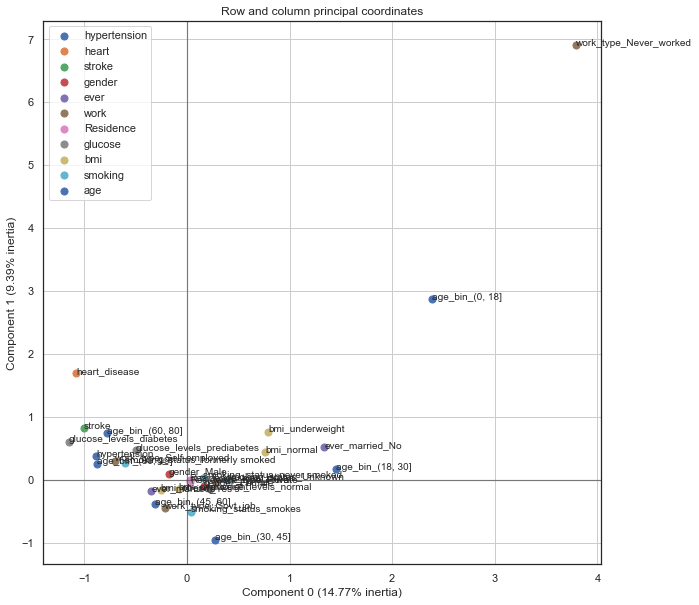

In [63]:
mca.plot_coordinates(X=X1, show_row_points=False,
                     figsize=(10, 10),
                     show_column_labels=True,
                     column_points_size=50
                    );

In [64]:
print(mca.eigenvalues_, mca.total_inertia_, mca.explained_inertia_, sep='\n')

[0.25503785586098604, 0.1621353459029907]
1.7272727272727273
[0.1476534954984656, 0.09386783183857356]


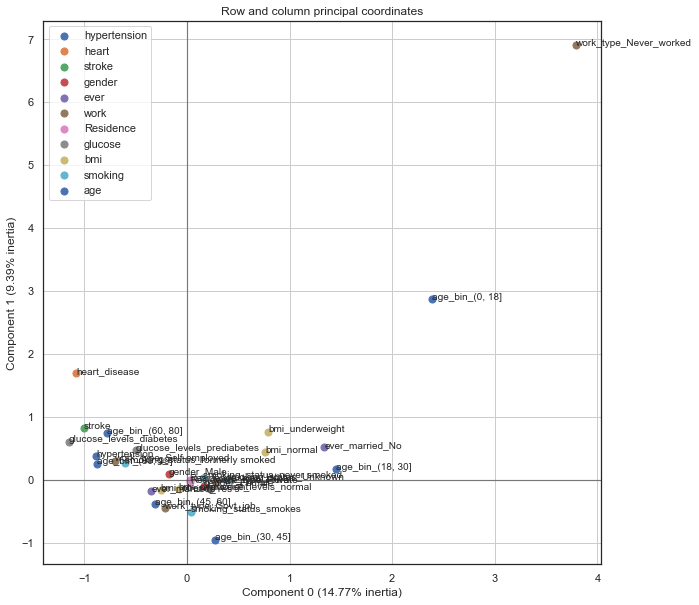

In [65]:
mca.plot_coordinates(X=X1, show_row_points=False,
                     figsize=(10, 10),
                     show_column_labels=True,
                     column_points_size=50
                    );

### PCA

In [66]:
from sklearn.decomposition import PCA

In [67]:
pca = PCA(n_components=7) 
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             ,columns = ['principal component 1', 'principal component 2','principl component 3','principal component 4','principal component 5','principal component 6','principal component 7'])
#finalDf = pd.concat([principalDf, y], axis = 1)

In [68]:
print('Given number of components explains', round(pca.explained_variance_ratio_.sum()*100,2), '% of variance')

Given number of components explains 94.2 % of variance


In [69]:
pca = PCA(0.9) 
principalComponents = pca.fit_transform(X)
print('Number of components explaining 90% variance: ', pca.n_components_)

Number of components explaining 90% variance:  6
